# Regression on a given dataset

The goal of this notebook is to perform regression on a given dataset. We will load a dataset, train a regression model, and evaluate its performance.

For more information on the evaluation and the used models, go at the bottom.

# 🎓 Library

In [ ]:
# Misc
import numpy as np
import pandas as pd
import os

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Models & tuning
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, QuantileRegressor, BayesianRidge, ElasticNet

# Metrics
from sklearn.metrics import r2_score
# Plot
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Environment variables

RAW_DATA = f"{os.getcwd()}/data"
SEED = 42

print(f"RAW_DATA: {RAW_DATA}")

RAW_DATA: /home/tofeha/ING2/ING2/FTML/FTML-Project/4.Regression_on_a_given_dataset/data


We extract our data

In [3]:
X_train = np.load(f"{RAW_DATA}/X_train.npy")
y_train = np.load(f"{RAW_DATA}/y_train.npy").ravel()

X_test = np.load(f"{RAW_DATA}/X_test.npy")
y_test = np.load(f"{RAW_DATA}/y_test.npy").ravel()

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((200, 200), (200,), (200, 200), (200,))

## Correlation matrix

Let's see the correlation matrix of the dataset to understand the relationships between features.

In [5]:
feature_corr = np.corrcoef(X_train, rowvar=False)

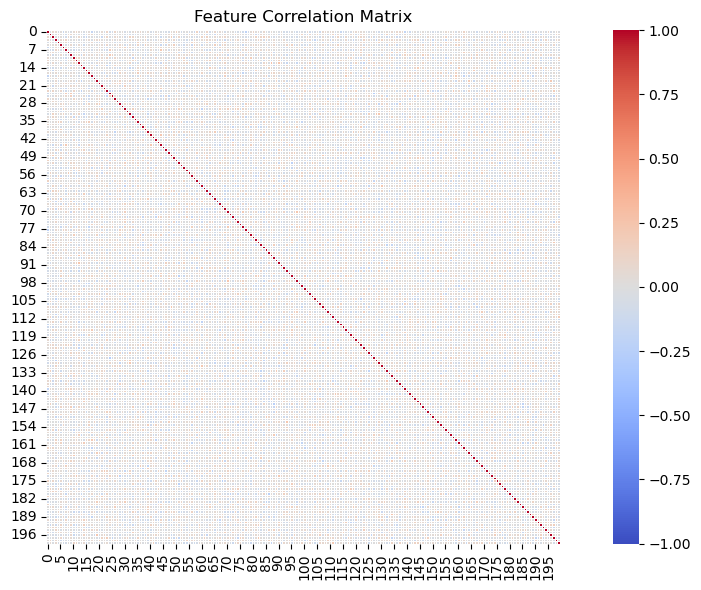

In [6]:
plt.figure(figsize=(11, 6))
sns.heatmap(feature_corr,
            annot=False,
            fmt=".2f",
            cmap="coolwarm",
            square=True,
            linewidths=0.5,
            vmin=-1,
            vmax=1)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

Interpretation of this matrix depends on the model used.

## Step 1: Preprocessing

Scalling makes most models better, but not always necessary.


In [7]:
X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Step 2: Model creation

We will make a pipeline for each model, and select the best performing one.

Another way of doing this is a singular pipeline. For example:
<details>
<summary>Example here</summary>

```python
param_grid = [
    {
        "clf": [LinearRegression()],
        "clf__fit_intercept": [True, False],
        "clf__copy_X": [True, False],
    },
    {
        "clf": [QuantileRegressor()],
        "clf__alpha": [0.01, 0.1, 1, 10],
        "clf__quantile": [0.1, 0.5, 0.9],
    },
    {
        "clf": [BayesianRidge()],
        "clf__alpha_1": [1e-6, 1e-3, 1e-1],
        "clf__lambda_1": [1e-6, 1e-3, 1e-1],
        "clf__tol": [1e-3, 1e-4, 1e-5],
    },
    {
        "clf": [Ridge(random_state=SEED)],
        "clf__alpha": [0.01, 0.1, 1, 10],
        "clf__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"],
    },
    {
        "clf": [Lasso(random_state=SEED)],
        "clf__alpha": [0.01, 0.1, 1, 10],
        "clf__max_iter": [1000, 5000, 10000],
        "clf__selection": ["cyclic", "random"],
    },
    {
        "clf": [ElasticNet(random_state=SEED)],
        "clf__alpha": [0.01, 0.1, 1, 10],
        "clf__l1_ratio": [0.1, 0.5, 0.9],
        "clf__max_iter": [1000, 5000, 10000],
    },
]
```

</details>

In [8]:
regressor_with_params : list[tuple] = [
    (
        LinearRegression(),
        {
            "linearregression__fit_intercept": [True, False],
            "linearregression__copy_X": [True, False],
        }
    ),
    (
        QuantileRegressor(),
        {
            "quantileregressor__alpha": [0.01, 0.1, 1, 10],
            "quantileregressor__quantile": [0.1, 0.5, 0.9],
        }
    ),
    (
        BayesianRidge(),
        {
            "bayesianridge__alpha_1": [1e-6, 1e-3, 1e-1],
            "bayesianridge__lambda_1": [1e-6, 1e-3, 1e-1],
            "bayesianridge__tol": [1e-3, 1e-4, 1e-5],
        }
    ),
    (
        Ridge(random_state=SEED),
        {
            "ridge__alpha": [0.01, 0.1, 1, 10],
            "ridge__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"],
        }
    ),
    (
        Lasso(random_state=SEED),
        {
            "lasso__alpha": [0.01, 0.1, 1, 10],
            "lasso__max_iter": [1000, 5000, 10000],
            "lasso__selection": ["cyclic", "random"],
        }
    ),
    (
        ElasticNet(random_state=SEED),
        {
            "elasticnet__alpha": [0.01, 0.1, 1, 10],
            "elasticnet__l1_ratio": [0.1, 0.5, 0.9],
            "elasticnet__max_iter": [1000, 5000, 10000],
        }
    )
    
]


## Step 3: Training & Evaluation

### Training

In [13]:
best_model = None
best_test_score = -np.inf

for regressor, param_grid in regressor_with_params:
    pipeline = make_pipeline(regressor)
    
    search_space = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    try:
        search_space.fit(X_train_scaled, y_train)
    except ValueError as e:
        print(f"Error fitting {regressor.__class__.__name__}: {e}")
        continue

    test_score = r2_score(y_test, search_space.predict(X_test_scaled))

    print(f"\n{regressor.__class__.__name__}")
    print(f"Best CV score: {search_space.best_score_:.4f}")
    print(f"Test R^2 score: {test_score:.4f}")
    
    if test_score > best_test_score:
        best_test_score = test_score
        # We take the model with the best set of parameters
        best_model = search_space.best_estimator_

print(f"\nBest regressor overall: {best_model[0].__class__.__name__} with test score = {best_test_score:.4f}")



LinearRegression
Best CV score: 0.4493
Test R^2 score: -9.9240

QuantileRegressor
Best CV score: 0.8880
Test R^2 score: 0.8732

BayesianRidge
Best CV score: 0.5652
Test R^2 score: 0.7120

Ridge
Best CV score: 0.5709
Test R^2 score: 0.7153

Lasso
Best CV score: 0.9164
Test R^2 score: 0.9196

ElasticNet
Best CV score: 0.9129
Test R^2 score: 0.9184

Best regressor overall: Lasso with test score = 0.9196


In [14]:
model = best_model
model

Pipeline(steps=[('lasso', Lasso(alpha=0.01, random_state=42))])

In [15]:
y_pred = model.predict(X_test_scaled)

### Evaluation

In [12]:
model.score(X_test_scaled, y_test)

0.9195566713927862

In [14]:
r2_score_value = r2_score(y_test, y_pred)
print(f"R^2 score: {r2_score_value:.4f}")

R^2 score: 0.9196


### Exploration
This notebook uses the following models:
- `LinearRegression`
- `QuantileRegressor`
- `BayesianRidge`
- `Ridge`
- `Lasso`
- `ElasticNet`

These models are wrapped in a `imblearn.pipeline.Pipeline` to allow for easy hyperparameter tuning and evaluation.

The dataset contains many features, we noticed that PCA reduction did not improve the performance of the models. Therefore, we will not use PCA in this notebook.

### Conclusion
The worse performing model is `LinearRegression`. This is coherent with the correlation matrix, which shows that the features are not linearly correlated with the target variable. Therefore, the other models are better suited for this dataset, as they can capture non-linear relationships.

The best performing model is `Lasso`. This model is effective in handling high-dimensional datasets and can perform feature selection by driving some coefficients to zero. 

Overall, the models that performed well are those that can handle non-linear relationships and high-dimensional datasets. The `Lasso` model stands out as the best performer with an R2 score of 0.9196 on the test set.
